In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SALib.analyze import sobol
from SALib.sample import saltelli
from matplotlib import offsetbox
from sklearn import manifold
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.tab20((y[i]+0.5) / 20.),
                 fontdict={'weight': 'bold', 'size': 8})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            # imagebox = offsetbox.AnnotationBbox(
            #     offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            #     X[i])
            # ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [15]:
def calculate_fit(label_group):
    label = label_group[0]
    neighs = len(label_group) - 1
    s = 1.
    for l in label_group[1:]:
        if l != label:
            s -= 1. / neighs
    return s


def calculate_nn_metric(X, y, neighs) -> float:
    nbrs = NearestNeighbors(n_neighbors=neighs).fit(X)
    _, indices = nbrs.kneighbors(X)
    return sum(map(lambda ind: calculate_fit(y[ind]), indices)) / len(y)


def perform_embedding(X, y, perplexity, early_exaggeration, learning_rate, n_iter, init, random_state, angle) -> float:
    tsne = manifold.TSNE(n_components=2, metric='cosine', perplexity=perplexity, early_exaggeration=early_exaggeration, learning_rate=learning_rate, n_iter=int(n_iter), init=('random' if init < 0.5 else 'pca'), random_state=int(random_state), angle=angle)
    return tsne.fit_transform(X)

In [5]:
problem = {
    'num_vars': 7,
    'names': ['perplexity', 'early_exaggeration', 'learning_rate', 'n_iter', 'init', 'random_state', 'angle'],
    'bounds': [
        [5.0, 50.0],
        [1.0, 100.0],
        [10.0, 1000.0],
        [250, 2500],
        [0.0, 1.0],
        [0.0, 1000.0],
        [0.2, 0.8]
    ]
}

In [6]:
data_text, labels = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [7]:
n_features = 60000
tfidf_vectorizer = TfidfVectorizer(max_features=n_features,
                                   stop_words='english')

data = tfidf_vectorizer.fit_transform(data_text)

data.shape

(11314, 60000)

In [8]:
X = TruncatedSVD(n_components=50).fit_transform(data)

y = labels

In [9]:
N = 20
samples = saltelli.sample(problem, N)
np.savez('samples_tng.npz', samples)

In [10]:
import multiprocessing
from multiprocessing import Pool, Value
import time

In [11]:
def embedding(sample):
    global counter
    with counter.get_lock():
        counter.value += 1
        step = counter.value
    print('Starting to calculate ' + str(step) + ' of ' + str(len(samples)) + ' (sample ' + str(["{0:0.2f}".format(i) for i in sample]) + ')')
    t = time.process_time()
    embed = perform_embedding(X, y, *sample)
    elapsed_time = time.process_time() - t
    print('Calculation complete for ' + str(step) + ' of ' + str(len(samples)) + ' in ' + str(elapsed_time) + ' s.')
    return [embed, elapsed_time]

In [14]:
counter = Value('i', 0)

with Pool(processes=6) as pool:
    embeddings_with_times = pool.map(embedding, samples)
    
np.savez('embeds_with_time.npz', np.array(embeddings_with_times))

Starting to calculate 1 of 320 (sample ['14.89', '10.57', '523.37', '1772.71', '0.28', '907.23', '0.23'])
Starting to calculate 6 of 320 (sample ['20.51', '47.70', '152.12', '928.96', '0.16', '286.13', '0.45'])
Starting to calculate 5 of 320 (sample ['26.14', '75.35', '326.14', '1003.66', '0.00', '911.13', '0.58'])
Starting to calculate 4 of 320 (sample ['11.72', '25.85', '770.87', '2128.66', '0.50', '411.13', '0.28'])
Starting to calculate 3 of 320 (sample ['22.97', '1.10', '573.64', '1566.16', '0.78', '661.13', '0.73'])
Starting to calculate 2 of 320 (sample ['45.47', '50.60', '78.64', '441.16', '0.25', '161.13', '0.23'])
Calculation complete for 2 of 320 in 569.1740262989999 s.
Starting to calculate 7 of 320 (sample ['45.47', '50.60', '78.64', '441.16', '0.25', '161.13', '0.43'])
Calculation complete for 6 of 320 in 975.4572452079999 s.
Starting to calculate 8 of 320 (sample ['20.51', '47.70', '152.12', '928.96', '0.16', '782.23', '0.66'])
Calculation complete for 5 of 320 in 992.27

Calculation complete for 46 of 320 in 2092.634996234001 s.
Starting to calculate 53 of 320 (sample ['11.72', '25.85', '821.14', '2128.66', '0.50', '411.13', '0.28'])
Calculation complete for 48 of 320 in 1355.8376921889994 s.
Starting to calculate 54 of 320 (sample ['22.97', '1.10', '573.64', '647.71', '0.75', '661.13', '0.73'])
Calculation complete for 50 of 320 in 927.6464934679989 s.
Starting to calculate 55 of 320 (sample ['20.51', '47.70', '152.12', '2409.91', '0.16', '782.23', '0.45'])
Calculation complete for 54 of 320 in 573.0432782039989 s.
Starting to calculate 56 of 320 (sample ['43.01', '97.20', '647.12', '1284.91', '0.66', '282.23', '0.75'])
Calculation complete for 49 of 320 in 2351.739541256 s.
Starting to calculate 57 of 320 (sample ['48.64', '35.32', '821.14', '2335.21', '0.53', '157.23', '0.38'])
Calculation complete for 51 of 320 in 2069.1653246019996 s.
Starting to calculate 58 of 320 (sample ['14.89', '10.57', '523.37', '1772.71', '0.28', '907.23', '0.43'])
Calcula

Calculation complete for 92 of 320 in 2418.706235513997 s.
Starting to calculate 103 of 320 (sample ['48.64', '35.32', '770.87', '2335.21', '0.53', '157.23', '0.28'])
Calculation complete for 100 of 320 in 745.2368843330005 s.
Starting to calculate 104 of 320 (sample ['39.85', '62.97', '449.89', '722.41', '0.88', '36.13', '0.30'])
Calculation complete for 99 of 320 in 1152.748836466999 s.
Starting to calculate 105 of 320 (sample ['17.35', '13.47', '944.89', '1847.41', '0.38', '536.13', '0.60'])
Calculation complete for 101 of 320 in 1304.730885904999 s.
Starting to calculate 106 of 320 (sample ['9.26', '72.45', '944.89', '1491.46', '0.41', '532.23', '0.60'])
Calculation complete for 98 of 320 in 1861.585017497 s.
Starting to calculate 107 of 320 (sample ['43.01', '97.20', '202.39', '2053.96', '0.66', '282.23', '0.75'])
Calculation complete for 104 of 320 in 872.2413316250022 s.
Starting to calculate 108 of 320 (sample ['39.85', '62.97', '449.89', '722.41', '0.88', '36.13', '0.51'])
Cal

Calculation complete for 143 of 320 in 1951.5685456410029 s.
Starting to calculate 152 of 320 (sample ['19.11', '94.10', '801.81', '1843.02', '0.87', '0.98', '0.79'])
Calculation complete for 149 of 320 in 701.3148152600043 s.
Starting to calculate 153 of 320 (sample ['41.61', '44.60', '306.81', '1355.22', '0.37', '500.98', '0.62'])
Calculation complete for 142 of 320 in 2308.3246559860017 s.
Starting to calculate 154 of 320 (sample ['18.75', '69.35', '554.31', '2405.52', '0.12', '750.98', '0.47'])
Calculation complete for 150 of 320 in 688.8687795060032 s.
Starting to calculate 155 of 320 (sample ['7.50', '78.44', '666.46', '1355.22', '0.37', '192.38', '0.49'])
Calculation complete for 151 of 320 in 1081.0227601470033 s.
Starting to calculate 156 of 320 (sample ['7.86', '19.85', '59.31', '1280.52', '0.62', '250.98', '0.34'])
Calculation complete for 153 of 320 in 1293.4930054029974 s.
Starting to calculate 157 of 320 (sample ['41.61', '44.60', '306.81', '718.02', '0.97', '500.98', '0.

Calculation complete for 193 of 320 in 2626.4550960900015 s.
Starting to calculate 201 of 320 (sample ['47.23', '81.73', '183.06', '436.77', '0.85', '875.98', '0.25'])
Calculation complete for 198 of 320 in 1454.746876422003 s.
Starting to calculate 202 of 320 (sample ['13.13', '90.82', '790.21', '1073.97', '1.00', '67.38', '0.56'])
Calculation complete for 197 of 320 in 1920.3848785739974 s.
Starting to calculate 203 of 320 (sample ['35.98', '16.57', '925.56', '2124.27', '0.25', '625.98', '0.70'])
Calculation complete for 201 of 320 in 666.8549289420043 s.
Starting to calculate 204 of 320 (sample ['47.23', '81.73', '183.06', '436.77', '0.50', '567.38', '0.25'])
Calculation complete for 196 of 320 in 2171.633279427995 s.
Starting to calculate 205 of 320 (sample ['30.00', '28.94', '171.46', '2480.22', '0.47', '692.38', '0.32'])
Calculation complete for 199 of 320 in 2187.3589197679976 s.
Starting to calculate 206 of 320 (sample ['30.36', '53.69', '913.96', '792.72', '0.72', '942.38', '0

Calculation complete for 249 of 320 in 327.0363963889977 s.
Starting to calculate 250 of 320 (sample ['10.67', '38.42', '987.43', '296.14', '0.06', '63.48', '0.67'])
Calculation complete for 241 of 320 in 1924.326258055 s.
Starting to calculate 251 of 320 (sample ['35.98', '7.48', '925.56', '2124.27', '0.25', '625.98', '0.71'])
Calculation complete for 250 of 320 in 291.47947385900625 s.
Starting to calculate 252 of 320 (sample ['10.67', '97.00', '233.33', '370.85', '0.16', '504.88', '0.67'])
Calculation complete for 236 of 320 in 2502.4837169500024 s.
Starting to calculate 253 of 320 (sample ['35.63', '41.32', '295.21', '436.77', '0.85', '567.38', '0.26'])
Calculation complete for 246 of 320 in 1485.1411404309983 s.
Starting to calculate 254 of 320 (sample ['24.73', '32.23', '790.21', '1561.77', '1.00', '375.98', '0.55'])
Calculation complete for 248 of 320 in 1048.8872044570016 s.
Starting to calculate 255 of 320 (sample ['13.48', '56.98', '430.56', '511.47', '0.75', '125.98', '0.40'

Starting to calculate 298 of 320 (sample ['21.92', '63.17', '244.93', '1983.64', '0.31', '313.48', '0.22'])
Calculation complete for 295 of 320 in 2018.6220385780034 s.
Starting to calculate 299 of 320 (sample ['49.69', '22.75', '975.83', '2058.35', '0.91', '813.48', '0.52'])
Calculation complete for 296 of 320 in 2064.137230569002 s.
Starting to calculate 300 of 320 (sample ['38.44', '47.50', '728.33', '1495.85', '0.66', '4.88', '0.37'])
Calculation complete for 297 of 320 in 1509.2195094649942 s.
Calculation complete for 300 of 320 in 1630.8151133330102 s.
Starting to calculate 301 of 320 (sample ['44.42', '13.67', '739.93', '858.64', '0.81', '813.48', '0.66'])
Calculation complete for 299 of 320 in 2095.795969259998 s.
Starting to calculate 302 of 320 (sample ['49.69', '22.75', '975.83', '2058.35', '0.91', '754.88', '0.66'])
Calculation complete for 298 of 320 in 2519.721450518002 s.
Starting to calculate 303 of 320 (sample ['21.92', '72.25', '480.83', '933.35', '0.41', '254.88', '0

In [16]:
def get_metric(args):
    embedding, neighs = args
    global counter
    with counter.get_lock():
        counter.value += 1
        step = counter.value
    print('Starting to calculate ' + str(step) + ' of ' + str(len(embeddings)))
    t = time.process_time()
    metric = calculate_nn_metric(embedding, y, neighs)
    elapsed_time = time.process_time() - t
    print('Calculation complete for ' + str(step) + ' of ' + str(len(embeddings)) + ' in ' + str(elapsed_time) + ' s.')
    return metric

In [83]:
embeddings = [embeddings_arr for (embeddings_arr, time) in embeddings_with_times]

In [81]:
neighs_nums = [5, 11, 21,51]
Ys = []
for neighs in neighs_nums:
    counter = Value('i', 0)
    print("############# Calculation of metrics for {} neighs ###################".format(neighs))
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        Ys.append(pool.map(get_metric, [(embedding, neighs) for embedding in embeddings]))

############# Calculation of metrics for 5 neighs ###################
Starting to calculate 1 of 320
Starting to calculate 2 of 320
Starting to calculate 4 of 320
Starting to calculate 3 of 320
Starting to calculate 5 of 320
Starting to calculate 6 of 320
Starting to calculate 8 of 320
Starting to calculate 7 of 320
Starting to calculate 9 of 320
Calculation complete for 4 of 320 in 0.077361419 s.
Starting to calculate 10 of 320
Starting to calculate 11 of 320
Calculation complete for 1 of 320 in 0.082915862 s.
Calculation complete for 2 of 320 in 0.091170929 s.
Starting to calculate 12 of 320
Calculation complete for 6 of 320 in 0.07892267500000001 s.
Starting to calculate 13 of 320
Starting to calculate 14 of 320
Calculation complete for 3 of 320 in 0.087757373 s.
Starting to calculate 15 of 320
Calculation complete for 5 of 320 in 0.091883174 s.
Calculation complete for 9 of 320 in 0.089670539 s.
Starting to calculate 16 of 320
Calculation complete for 7 of 320 in 0.08151775 s.
Star

Starting to calculate 97 of 320
Calculation complete for 83 of 320 in 0.10663119300000001 s.
Calculation complete for 89 of 320 in 0.103841407 s.
Starting to calculate 98 of 320
Starting to calculate 99 of 320
Calculation complete for 90 of 320 in 0.10754207999999998 s.
Calculation complete for 91 of 320 in 0.09911652799999993 s.
Starting to calculate 100 of 320
Calculation complete for 93 of 320 in 0.09967585400000001 s.
Starting to calculate 101 of 320
Calculation complete for 92 of 320 in 0.10204306899999993 s.
Starting to calculate 102 of 320
Starting to calculate 103 of 320
Calculation complete for 94 of 320 in 0.1047287939999999 s.
Calculation complete for 95 of 320 in 0.08410874499999987 s.
Calculation complete for 96 of 320 in 0.0951273909999999 s.
Starting to calculate 104 of 320
Calculation complete for 98 of 320 in 0.09085362499999994 s.
Starting to calculate 106 of 320
Starting to calculate 105 of 320
Starting to calculate 107 of 320
Calculation complete for 99 of 320 in 0.

Starting to calculate 184 of 320
Starting to calculate 185 of 320
Calculation complete for 176 of 320 in 0.08666900599999994 s.
Calculation complete for 178 of 320 in 0.09224027600000007 s.
Calculation complete for 179 of 320 in 0.07788656099999991 s.
Calculation complete for 177 of 320 in 0.09653085800000016 s.
Starting to calculate 186 of 320
Starting to calculate 189 of 320
Starting to calculate 188 of 320
Starting to calculate 187 of 320
Calculation complete for 180 of 320 in 0.09560266700000009 s.
Starting to calculate 190 of 320
Calculation complete for 181 of 320 in 0.09021893399999992 s.
Starting to calculate 191 of 320
Calculation complete for 183 of 320 in 0.08758046299999989 s.
Calculation complete for 182 of 320 in 0.0857699580000002 s.
Starting to calculate 192 of 320
Starting to calculate 193 of 320
Calculation complete for 185 of 320 in 0.09557925500000009 s.
Calculation complete for 186 of 320 in 0.0810056309999998 s.
Calculation complete for 189 of 320 in 0.09079500999

Calculation complete for 262 of 320 in 0.0998396210000001 s.
Starting to calculate 272 of 320
Calculation complete for 265 of 320 in 0.08793332799999964 s.
Starting to calculate 273 of 320
Calculation complete for 264 of 320 in 0.098674645 s.
Calculation complete for 268 of 320 in 0.08192579300000036 s.
Calculation complete for 263 of 320 in 0.09359521799999992 s.
Starting to calculate 274 of 320
Calculation complete for 266 of 320 in 0.09525318600000032 s.
Starting to calculate 275 of 320
Starting to calculate 276 of 320
Starting to calculate 277 of 320
Calculation complete for 267 of 320 in 0.10091968200000023 s.
Calculation complete for 270 of 320 in 0.08773356399999965 s.
Starting to calculate 278 of 320
Starting to calculate 279 of 320
Calculation complete for 271 of 320 in 0.10027505999999997 s.
Calculation complete for 269 of 320 in 0.09518502599999978 s.
Starting to calculate 280 of 320
Calculation complete for 273 of 320 in 0.08595104300000012 s.
Starting to calculate 281 of 3

Calculation complete for 32 of 320 in 0.13677462099999999 s.
Calculation complete for 30 of 320 in 0.15037993700000002 s.
Starting to calculate 40 of 320
Starting to calculate 41 of 320
Calculation complete for 31 of 320 in 0.13714760800000003 s.
Calculation complete for 34 of 320 in 0.13993489600000003 s.
Starting to calculate 42 of 320
Calculation complete for 35 of 320 in 0.14275141899999994 s.
Starting to calculate 43 of 320
Starting to calculate 44 of 320
Calculation complete for 33 of 320 in 0.14638930100000003 s.
Starting to calculate 45 of 320
Calculation complete for 36 of 320 in 0.14180290399999995 s.
Calculation complete for 37 of 320 in 0.142576349 s.
Starting to calculate 46 of 320
Starting to calculate 47 of 320
Calculation complete for 38 of 320 in 0.13934176400000003 s.
Starting to calculate 48 of 320
Calculation complete for 41 of 320 in 0.10874423699999997 s.
Starting to calculate 49 of 320
Calculation complete for 40 of 320 in 0.134466227 s.
Starting to calculate 50 

Calculation complete for 119 of 320 in 0.12484851800000007 s.
Starting to calculate 129 of 320
Calculation complete for 120 of 320 in 0.13530613899999988 s.
Calculation complete for 122 of 320 in 0.13836089000000018 s.
Starting to calculate 130 of 320
Starting to calculate 131 of 320
Calculation complete for 121 of 320 in 0.13838212900000002 s.
Starting to calculate 132 of 320
Calculation complete for 127 of 320 in 0.1246246740000001 s.
Starting to calculate 133 of 320
Calculation complete for 124 of 320 in 0.14232418000000013 s.
Starting to calculate 134 of 320
Calculation complete for 125 of 320 in 0.1464348769999999 s.
Calculation complete for 126 of 320 in 0.13438994399999982 s.
Starting to calculate 135 of 320
Starting to calculate 136 of 320
Calculation complete for 123 of 320 in 0.14263872099999997 s.
Starting to calculate 137 of 320
Calculation complete for 128 of 320 in 0.13673489399999994 s.
Starting to calculate 138 of 320
Calculation complete for 130 of 320 in 0.12782123300

Starting to calculate 214 of 320
Starting to calculate 215 of 320
Starting to calculate 216 of 320
Calculation complete for 206 of 320 in 0.13860138099999997 s.
Starting to calculate 217 of 320
Calculation complete for 209 of 320 in 0.1400401950000001 s.
Calculation complete for 208 of 320 in 0.14353019999999983 s.
Starting to calculate 218 of 320
Starting to calculate 219 of 320
Calculation complete for 211 of 320 in 0.13654753000000008 s.
Calculation complete for 210 of 320 in 0.1534385450000002 s.
Starting to calculate 220 of 320
Starting to calculate 221 of 320
Calculation complete for 212 of 320 in 0.14112642200000014 s.
Starting to calculate 222 of 320
Calculation complete for 216 of 320 in 0.12154937300000013 s.
Starting to calculate 223 of 320
Calculation complete for 214 of 320 in 0.13207763999999989 s.
Starting to calculate 224 of 320
Calculation complete for 215 of 320 in 0.15078016100000013 s.
Starting to calculate 225 of 320
Calculation complete for 217 of 320 in 0.1338932

Calculation complete for 293 of 320 in 0.13160903499999943 s.
Starting to calculate 303 of 320
Calculation complete for 294 of 320 in 0.12227037600000035 s.
Starting to calculate 304 of 320
Calculation complete for 296 of 320 in 0.14032432499999992 s.
Calculation complete for 295 of 320 in 0.13591768700000006 s.
Starting to calculate 305 of 320
Starting to calculate 306 of 320
Calculation complete for 297 of 320 in 0.1512279679999997 s.
Calculation complete for 298 of 320 in 0.14381016499999966 s.
Starting to calculate 307 of 320
Starting to calculate 308 of 320
Calculation complete for 302 of 320 in 0.13393630300000048 s.
Calculation complete for 299 of 320 in 0.1454757390000001 s.
Calculation complete for 301 of 320 in 0.13426635099999995 s.
Starting to calculate 310 of 320
Starting to calculate 311 of 320
Calculation complete for 300 of 320 in 0.14444018599999975 s.
Starting to calculate 309 of 320
Calculation complete for 303 of 320 in 0.140235444 s.
Starting to calculate 312 of 32

Starting to calculate 71 of 320
Starting to calculate 72 of 320
Calculation complete for 62 of 320 in 0.2165226189999998 s.
Starting to calculate 73 of 320
Calculation complete for 64 of 320 in 0.20110040299999987 s.
Starting to calculate 74 of 320
Calculation complete for 68 of 320 in 0.18221635899999988 s.
Starting to calculate 75 of 320
Calculation complete for 66 of 320 in 0.21400921500000014 s.
Calculation complete for 65 of 320 in 0.21191219800000005 s.
Starting to calculate 76 of 320
Starting to calculate 77 of 320
Calculation complete for 67 of 320 in 0.1998291350000001 s.
Starting to calculate 78 of 320
Calculation complete for 70 of 320 in 0.1958543610000001 s.
Starting to calculate 79 of 320
Calculation complete for 69 of 320 in 0.20055698700000013 s.
Starting to calculate 80 of 320
Calculation complete for 71 of 320 in 0.19873743100000008 s.
Starting to calculate 81 of 320
Calculation complete for 72 of 320 in 0.1996223399999999 s.
Starting to calculate 82 of 320
Calculatio

Starting to calculate 158 of 320
Starting to calculate 160 of 320
Calculation complete for 153 of 320 in 0.2210207350000002 s.
Starting to calculate 161 of 320
Calculation complete for 154 of 320 in 0.23303663399999985 s.
Starting to calculate 162 of 320
Calculation complete for 148 of 320 in 0.236196364 s.
Starting to calculate 163 of 320
Calculation complete for 152 of 320 in 0.22164577900000015 s.
Starting to calculate 164 of 320
Calculation complete for 157 of 320 in 0.166522713 s.
Starting to calculate 165 of 320
Calculation complete for 155 of 320 in 0.23544095399999998 s.
Starting to calculate 166 of 320
Calculation complete for 159 of 320 in 0.21979402799999992 s.
Starting to calculate 167 of 320
Calculation complete for 158 of 320 in 0.20865047300000006 s.
Starting to calculate 168 of 320
Calculation complete for 160 of 320 in 0.21405813100000026 s.
Starting to calculate 169 of 320
Calculation complete for 162 of 320 in 0.2081914730000003 s.
Starting to calculate 170 of 320
Ca

Starting to calculate 246 of 320
Starting to calculate 247 of 320
Calculation complete for 239 of 320 in 0.21707804000000053 s.
Starting to calculate 248 of 320
Calculation complete for 238 of 320 in 0.23508368100000077 s.
Starting to calculate 249 of 320
Calculation complete for 240 of 320 in 0.2082317119999999 s.
Calculation complete for 241 of 320 in 0.21279660499999942 s.
Starting to calculate 251 of 320
Calculation complete for 242 of 320 in 0.21082093999999962 s.
Starting to calculate 250 of 320
Calculation complete for 243 of 320 in 0.20920602099999996 s.
Starting to calculate 252 of 320
Calculation complete for 244 of 320 in 0.21198158300000003 s.
Starting to calculate 253 of 320
Starting to calculate 254 of 320
Calculation complete for 245 of 320 in 0.21958863200000067 s.
Starting to calculate 255 of 320
Calculation complete for 246 of 320 in 0.20572691799999987 s.
Starting to calculate 256 of 320
Calculation complete for 247 of 320 in 0.22354392899999986 s.
Starting to calcul

Starting to calculate 12 of 320
Starting to calculate 13 of 320
Calculation complete for 9 of 320 in 0.4528927850000001 s.
Starting to calculate 14 of 320
Calculation complete for 5 of 320 in 0.449470378 s.
Starting to calculate 15 of 320
Starting to calculate 16 of 320
Calculation complete for 10 of 320 in 0.475461475 s.
Calculation complete for 7 of 320 in 0.456343659 s.
Starting to calculate 18 of 320
Starting to calculate 17 of 320
Calculation complete for 8 of 320 in 0.453971249 s.
Calculation complete for 3 of 320 in 0.475263368 s.
Starting to calculate 19 of 320
Starting to calculate 20 of 320
Calculation complete for 11 of 320 in 0.471756134 s.
Starting to calculate 21 of 320
Calculation complete for 12 of 320 in 0.481699096 s.
Starting to calculate 22 of 320
Calculation complete for 14 of 320 in 0.47416547700000006 s.
Starting to calculate 23 of 320
Calculation complete for 15 of 320 in 0.5044795950000001 s.
Starting to calculate 24 of 320
Calculation complete for 13 of 320 in

Starting to calculate 104 of 320
Calculation complete for 95 of 320 in 0.47025432599999917 s.
Starting to calculate 105 of 320
Calculation complete for 96 of 320 in 0.44836736199999994 s.
Starting to calculate 106 of 320
Calculation complete for 97 of 320 in 0.4458511440000006 s.
Starting to calculate 107 of 320
Calculation complete for 98 of 320 in 0.4587820530000002 s.
Starting to calculate 108 of 320
Calculation complete for 100 of 320 in 0.40417429799999915 s.
Starting to calculate 109 of 320
Calculation complete for 99 of 320 in 0.45847049500000026 s.
Starting to calculate 110 of 320
Calculation complete for 102 of 320 in 0.4592853470000007 s.
Starting to calculate 111 of 320
Calculation complete for 101 of 320 in 0.4716943590000007 s.
Starting to calculate 112 of 320
Calculation complete for 103 of 320 in 0.4493101700000004 s.
Starting to calculate 113 of 320
Calculation complete for 104 of 320 in 0.4436826399999996 s.
Calculation complete for 105 of 320 in 0.4225920119999991 s.


Calculation complete for 182 of 320 in 0.4359838449999991 s.
Starting to calculate 192 of 320
Calculation complete for 183 of 320 in 0.457244836000001 s.
Starting to calculate 193 of 320
Calculation complete for 185 of 320 in 0.46794076200000045 s.
Starting to calculate 194 of 320
Calculation complete for 186 of 320 in 0.4561945509999994 s.
Starting to calculate 195 of 320
Calculation complete for 184 of 320 in 0.4731144159999996 s.
Starting to calculate 196 of 320
Calculation complete for 189 of 320 in 0.49373773400000154 s.
Starting to calculate 197 of 320
Calculation complete for 190 of 320 in 0.499540283 s.
Starting to calculate 198 of 320
Calculation complete for 187 of 320 in 0.4924069539999998 s.
Calculation complete for 191 of 320 in 0.5063345229999996 s.
Starting to calculate 200 of 320
Starting to calculate 199 of 320
Calculation complete for 192 of 320 in 0.4919948209999987 s.
Calculation complete for 188 of 320 in 0.5283471459999998 s.
Starting to calculate 201 of 320
Start

Starting to calculate 278 of 320
Starting to calculate 279 of 320
Calculation complete for 270 of 320 in 0.4544479419999998 s.
Starting to calculate 280 of 320
Calculation complete for 271 of 320 in 0.4489163350000016 s.
Starting to calculate 281 of 320
Calculation complete for 272 of 320 in 0.46679013900000044 s.
Starting to calculate 282 of 320
Calculation complete for 274 of 320 in 0.46221764599999915 s.
Starting to calculate 283 of 320
Calculation complete for 273 of 320 in 0.4671949480000013 s.
Starting to calculate 284 of 320
Calculation complete for 275 of 320 in 0.46038569000000074 s.
Starting to calculate 285 of 320
Calculation complete for 277 of 320 in 0.4661422179999999 s.
Starting to calculate 286 of 320
Calculation complete for 279 of 320 in 0.459411244 s.
Calculation complete for 278 of 320 in 0.46435608700000053 s.
Starting to calculate 287 of 320
Starting to calculate 288 of 320
Calculation complete for 276 of 320 in 0.4596849540000001 s.
Starting to calculate 289 of 3

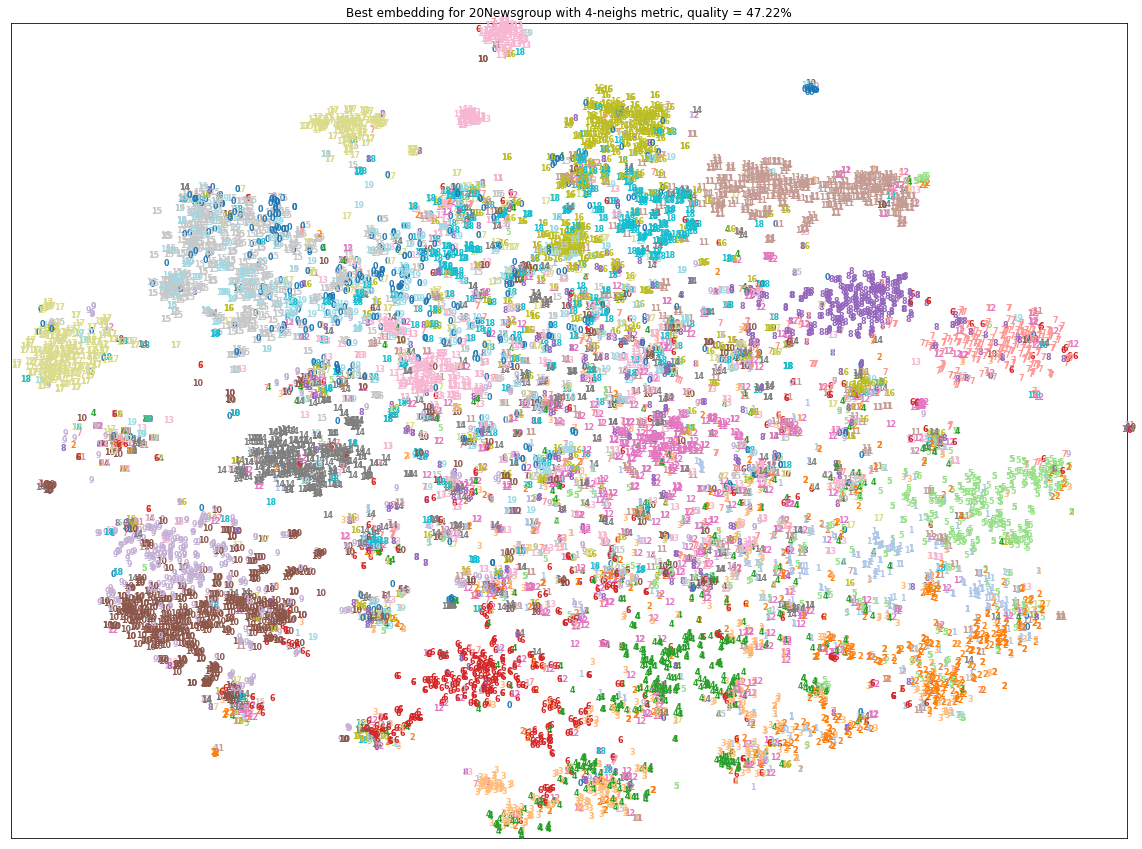

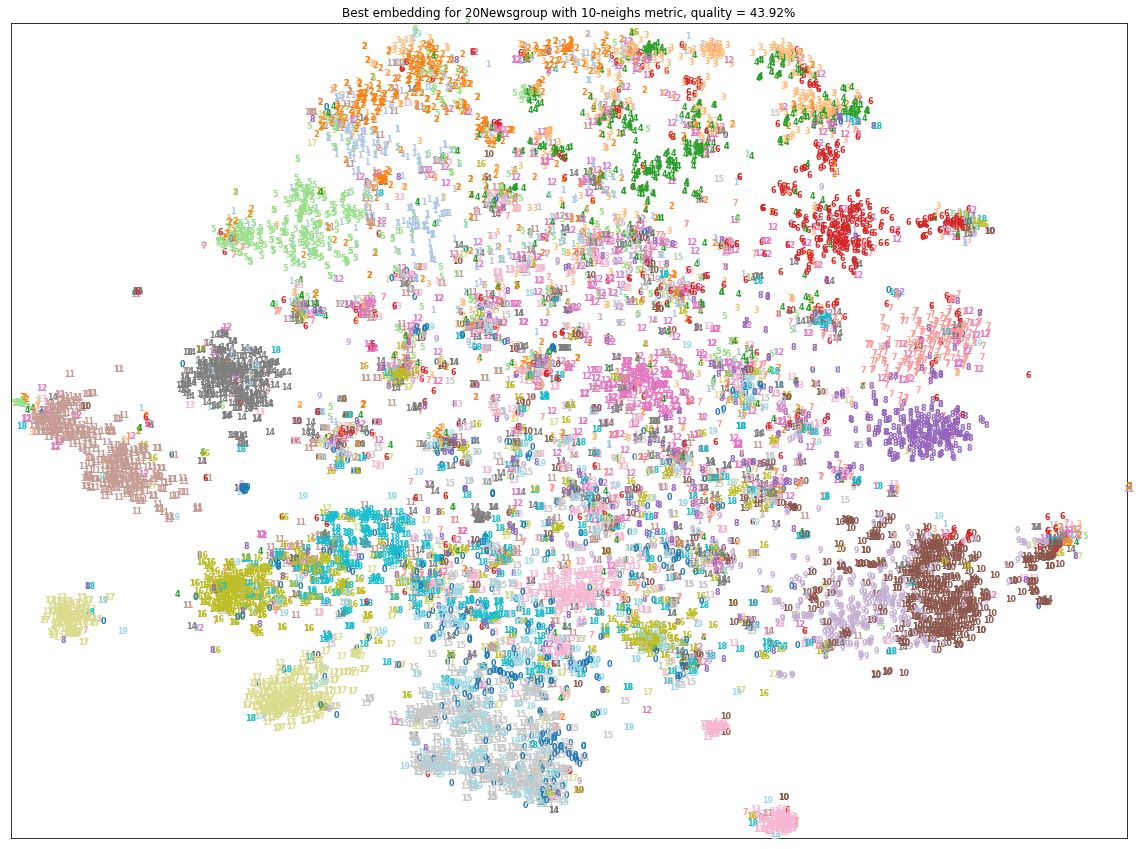

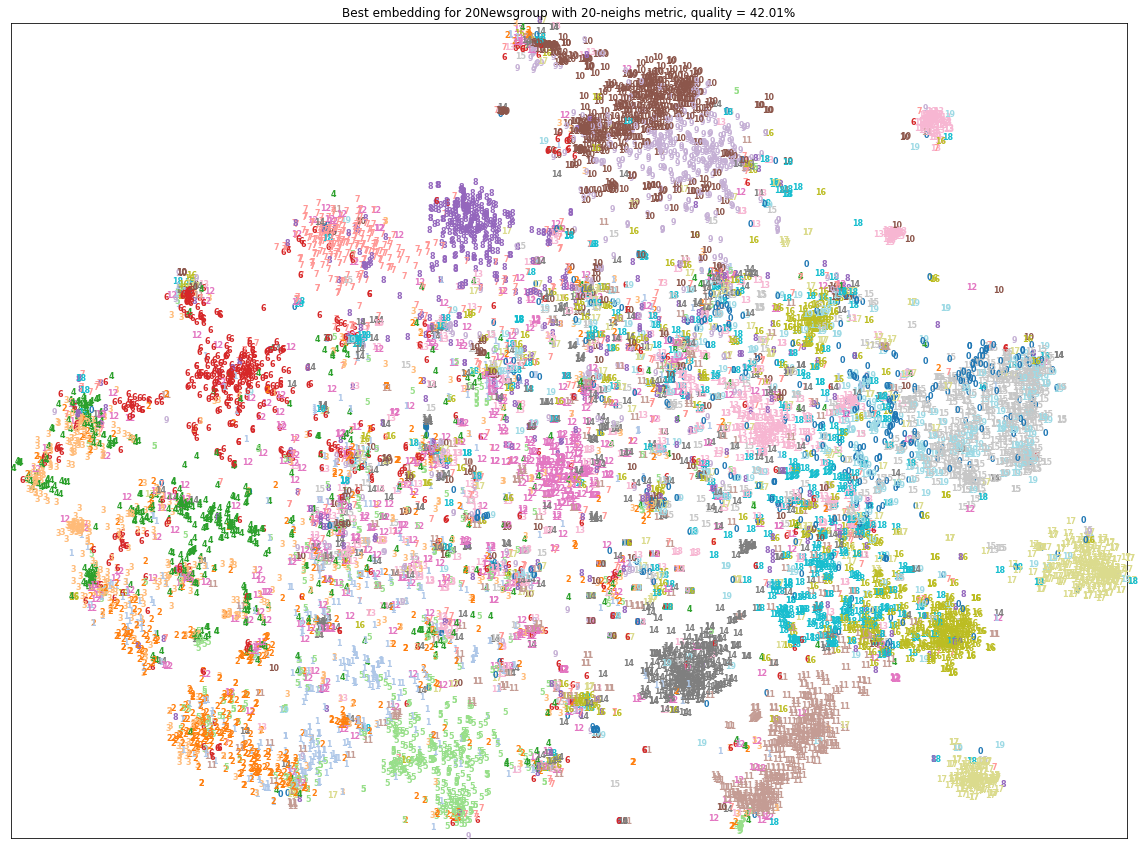

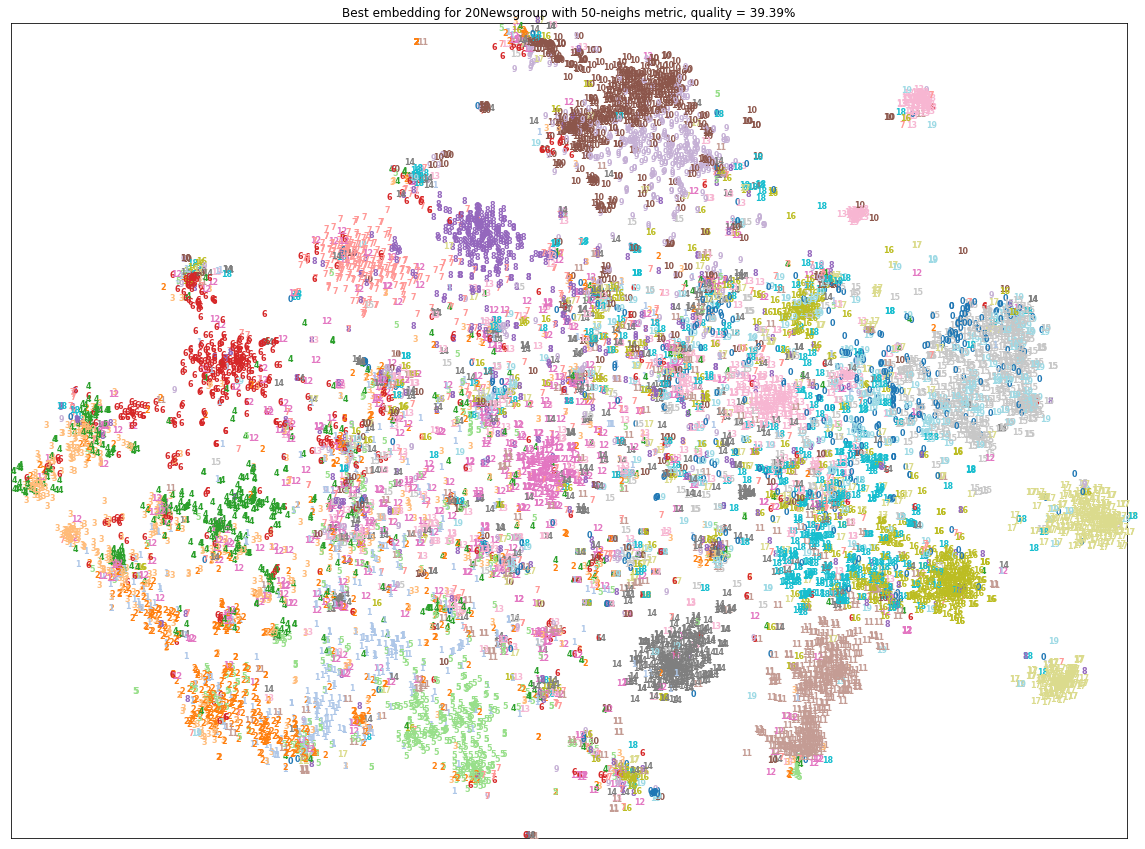

In [82]:
plt.rcParams['figure.figsize'] = (20,15)

for i, neighs in enumerate(neighs_nums):
    index = np.argmax(Ys[i])
    plot_embedding(embeddings[index], y, 
               title='Best embedding for 20Newsgroup with {}-neighs metric, quality = {:0.2f}%'.format(neighs-1, Ys[i][index]*100))

In [107]:
def plot_analysis(analysis_dfs, title=None):
    if len(analysis_dfs) == 1:
        fig, ax = plt.subplots(1)
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, len(analysis_dfs))
    fig.suptitle(title)
    for idx, f in enumerate(analysis_dfs):
        axes[idx] = barplot(f, ax=axes[idx])

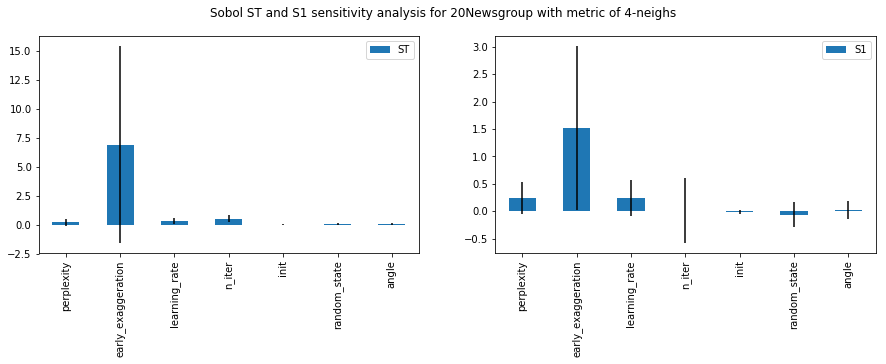

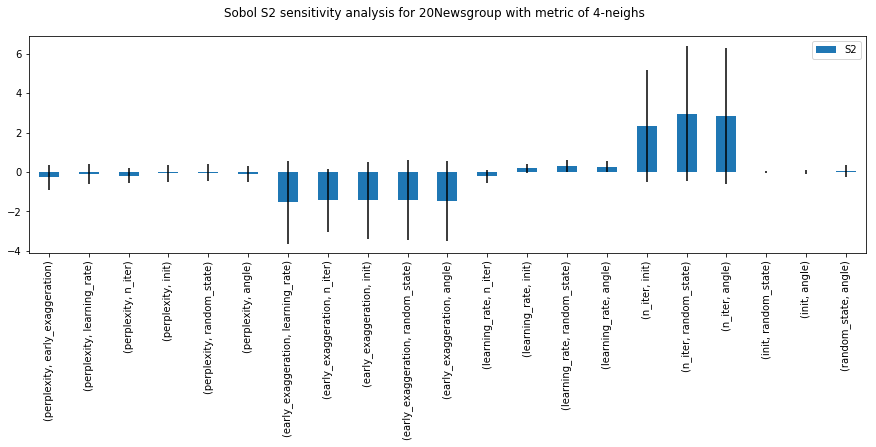

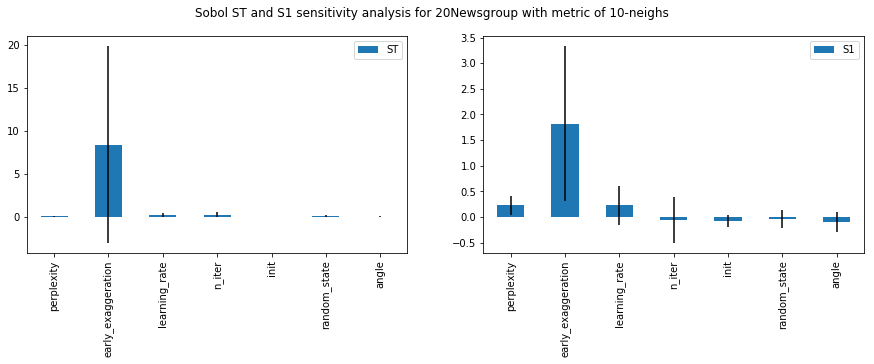

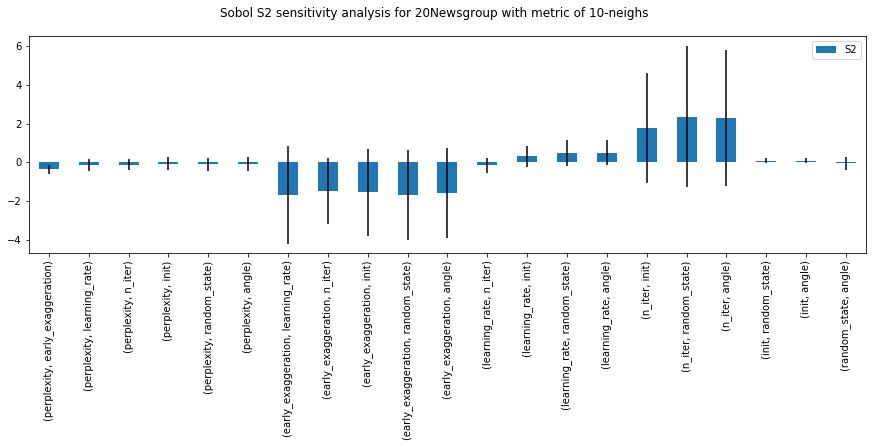

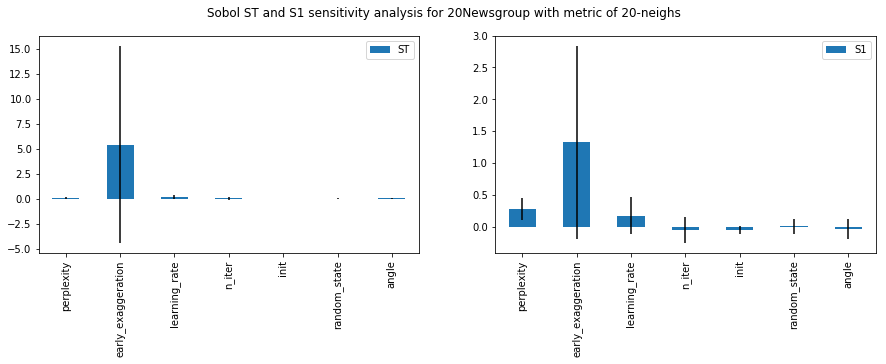

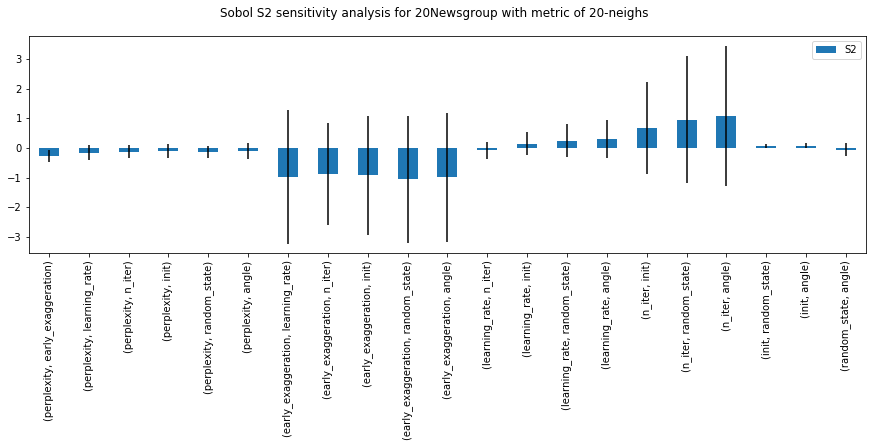

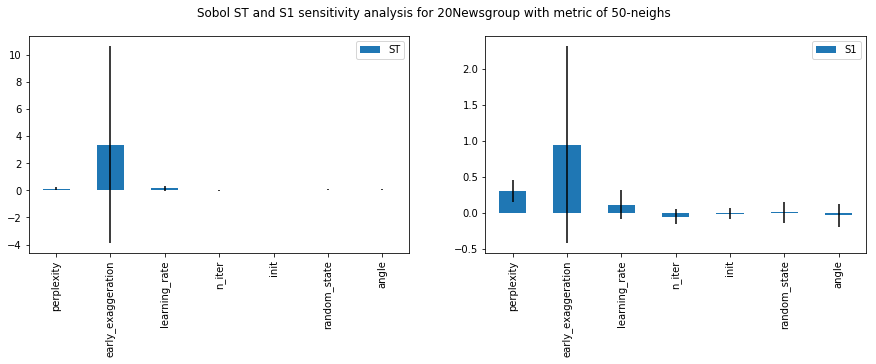

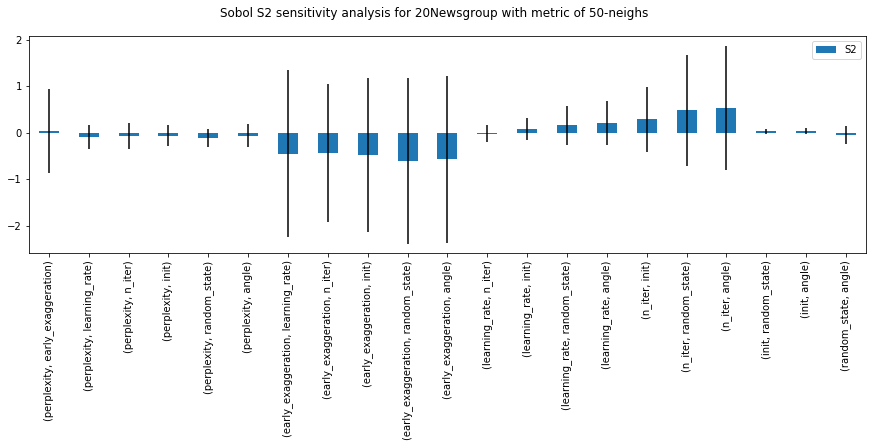

In [112]:
plt.rcParams['figure.figsize'] = (15, 4)
for i, neighs in enumerate(neighs_nums):
    sensitivity = sobol.analyze(problem, np.array(Ys[i]))
    df = sensitivity.to_df()
    plot_analysis(df[:-1], 'Sobol ST and S1 sensitivity analysis for 20Newsgroup with metric of {}-neighs'.format(neighs-1))
    plot_analysis(df[2:], 'Sobol S2 sensitivity analysis for 20Newsgroup with metric of {}-neighs'.format(neighs-1))